<a href="https://colab.research.google.com/github/stxupengyu/LSTM-for-Time-Series-Forecasting-Pytorch/blob/main/torch_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Project/torch_gru')
!ls

data.xls  gru_torch_3.ipynb  lstm_cnn_avg.ipynb
gru.h5	  gru_torch.ipynb    lstm_torch.ipynb


#Read data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchvision import transforms, datasets
plt.style.use('ggplot')

seq_length = 3#time step
input_size = 3#input dim
hidden_size = 6
num_layers = 1
num_classes = 1
learning_rate = 0.0001
batch_size = 64
n_iters = 5000
split_ratio = 0.9
data_path = 'data.xls'

def read_data(data_path):
  '''
  read original data, show and plot
  '''
  data = pd.read_excel(data_path)
  data=data.iloc[:,:3]
  label=data.iloc[:,2:]
  print(data.head())
  # plt.plot(data.iloc[:,0])
  # plt.show()
  return data,label

def normalization(data,label):
  '''
  normalization
  '''
  mm_x = MinMaxScaler()
  mm_y = MinMaxScaler()  
  data = data.values
  data = mm_x.fit_transform(data)
  label = mm_y.fit_transform(label)
  return data, label, mm_y

def sliding_windows(data, seq_length):
  '''
  Output:The data form we can feed GRU
  '''
  x = []
  y = []
  for i in range(len(data)-seq_length-1):
      _x = data[i:(i+seq_length),:]
      _y = data[i+seq_length,-1]
      x.append(_x)
      y.append(_y)
  x, y = np.array(x),np.array(y)
  print('x.shape,y.shape:\n',x.shape,y.shape)
  return x, y

def data_split(x, y, split_ratio):
  '''
  convert to torch format and split train&test
  '''
  train_size = int(len(y) * split_ratio)
  test_size = len(y) - train_size

  x_data = Variable(torch.Tensor(np.array(x)))
  y_data = Variable(torch.Tensor(np.array(y)))

  x_train = Variable(torch.Tensor(np.array(x[0:train_size])))
  y_train = Variable(torch.Tensor(np.array(y[0:train_size])))
  x_test = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
  y_test = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

  print('x_train.shape,y_train.shape,x_test.shape,y_test.shape:\n',x_train.shape,y_train.shape,x_test.shape,y_test.shape)  
  return x_data, y_data, x_train, y_train, x_test, y_test

def data_generator(x_train, y_train, x_test, y_test, n_iters, batch_size):
  '''
  generate DataLoader
  '''
  num_epochs = n_iters / (len(x_train) / batch_size)
  num_epochs = int(num_epochs)
  train_dataset = Data.TensorDataset(x_train, y_train)
  test_dataset = Data.TensorDataset(x_test, y_test)
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)
  test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)
  return train_loader, test_loader, num_epochs

data,label = read_data(data_path) 
data, label, mm_y = normalization(data, label)
x, y = sliding_windows(data, seq_length)
x_data, y_data, x_train, y_train, x_test, y_test = data_split(x, y, split_ratio)
train_loader, test_loader, num_epochs = data_generator(x_train, y_train, x_test, y_test, n_iters, batch_size)

   导叶开度  燃料流量m3N/h  压气机出口温度
0     1     0.0089      1.0
1     2     0.0179      2.0
2     3     0.0269      2.0
3     6     0.0359      3.0
4     8     0.0449      4.0
x.shape,y.shape:
 (604, 3, 3) (604,)
x_train.shape,y_train.shape,x_test.shape,y_test.shape:
 torch.Size([543, 3, 3]) torch.Size([543]) torch.Size([61, 3, 3]) torch.Size([61])


#Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BP(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(BP, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.fc1 = nn.Linear(seq_length*input_size, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):      
        out = x.view(-1, self.seq_length*self.input_size)     
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))#F.relu()
        out = self.fc3(out)
        return out

class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, 20)
        self.fc2 = nn.Linear(20, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))    
        # Propagate input through GRU
        ula, h_out  = self.gru(x, h_0)
        h_out = h_out.view(-1, self.hidden_size)
        out = F.relu(self.fc1(h_out))
        out = self.fc2(out)
        return out

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

mymodel = GRU(num_classes, input_size, hidden_size, num_layers)
print(mymodel)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(mymodel.parameters(), lr=learning_rate)

GRU(
  (gru): GRU(3, 6, batch_first=True)
  (fc1): Linear(in_features=6, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


#Train

In [ ]:
# Training 
iter=0 
for epochs in range(num_epochs):
  for i,(batch_x, batch_y) in enumerate (train_loader): 
    outputs = mymodel(batch_x)
    # clear the gradients
    optimizer.zero_grad()   
    #loss 
    #print(outputs.shape, batch_y.shape)
    loss = criterion(outputs,batch_y)
    #backpropagation 
    loss.backward()
    optimizer.step()
    iter+=1
    if iter % 100 == 0:
      print("iter: %d, loss: %1.5f" % (iter, loss.item()))


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter: 100, loss: 0.10608
iter: 200, loss: 0.09284
iter: 300, loss: 0.06052
iter: 400, loss: 0.03423
iter: 500, loss: 0.07159
iter: 600, loss: 0.11240
iter: 700, loss: 0.09758
iter: 800, loss: 0.12785
iter: 900, loss: 0.33978
iter: 1000, loss: 0.02314
iter: 1100, loss: 0.02443
iter: 1200, loss: 0.03547
iter: 1300, loss: 0.04117
iter: 1400, loss: 0.00918
iter: 1500, loss: 0.00558
iter: 1600, loss: 0.01549
iter: 1700, loss: 0.04192
iter: 1800, loss: 0.18253
iter: 1900, loss: 0.02118
iter: 2000, loss: 0.01910
iter: 2100, loss: 0.02834
iter: 2200, loss: 0.03339
iter: 2300, loss: 0.00790
iter: 2400, loss: 0.00500
iter: 2500, loss: 0.01217
iter: 2600, loss: 0.01992
iter: 2700, loss: 0.08916
iter: 2800, loss: 0.01007
iter: 2900, loss: 0.00780
iter: 3000, loss: 0.01581
iter: 3100, loss: 0.02103
iter: 3200, loss: 0.00580
iter: 3300, loss: 0.00492
iter: 3400, loss: 0.00907
iter: 3500, loss: 0.01127
iter: 3600, loss: 0.03063
iter: 3700, loss: 0.00367
iter: 3800, loss: 0.00119
iter: 3900, loss: 0.0

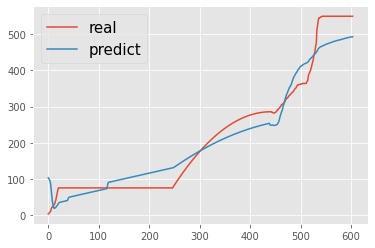

MAE/RMSE
33.589046
38.83998


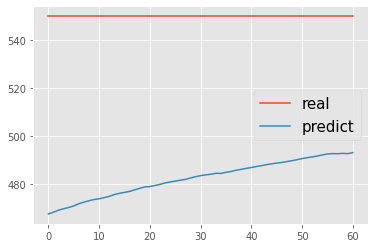

MAE/RMSE
67.69218
68.09824


In [ ]:
def result(x_data, y_data):
  mymodel.eval()
  train_predict = mymodel(x_data)

  data_predict = train_predict.data.numpy()
  y_data_plot = y_data.data.numpy()
  y_data_plot = np.reshape(y_data_plot, (-1,1))  
  data_predict = mm_y.inverse_transform(data_predict)
  y_data_plot = mm_y.inverse_transform(y_data_plot)

  plt.plot(y_data_plot)
  plt.plot(data_predict)
  plt.legend(('real', 'predict'),fontsize='15')
  plt.show()

  print('MAE/RMSE')
  print(mean_absolute_error(y_data_plot, data_predict))
  print(np.sqrt(mean_squared_error(y_data_plot, data_predict) ))

result(x_data, y_data)
result(x_test,y_test)